## Github Repo Metrics Using GraphQL API ##

text-processing.com provides a Sentiment Analysis API which has commercial licensing. 

It checks for neutrality first, ends if so, otherwise checks pos/neg

Vader is built on NLTK, open source, and worked previously for kono.

In [16]:
import requests
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
from string import Template

endpointSentAPI = 'http://text-processing.com/api/sentiment/'
endpointGitHub = 'https://api.github.com/graphql'
headersGitHub = {'Authorization': '<ADD YOUR TOKEN HERE>'}

def getSentimentAPI(phrase):
    r = requests.post(endpointSentAPI, {"text": phrase})
    return r.json()


In [17]:
analyzer = SentimentIntensityAnalyzer()

repoQuery = Template(''' 
{ 
    repository(owner: \"$owner\", name: \"$repo\") { 
        forkCount
        watchers(first: 10) {
            totalCount
        }
        stargazers(first: 10) {
            totalCount
        }
        
        commitComments(first: 10) {
            edges {
                node {
                    bodyText
                    reactions(first: 10) {
                        edges {
                            node {
                                content
                            }
                        }
                    }
                }
            }
        }
        pullRequests(first: 10) { 
            totalCount
            edges { 
                node { 
                    createdAt
                    closedAt
                    closed
                    merged
                    mergedAt
                    comments(first: 10) {
                        edges {
                            node {
                                bodyText
                            }
                        }
                    } 
                } 
            } 
        } 
        issues(first: 10) {
            totalCount
            edges {
                node {
                    createdAt
                    closedAt
                    closed
                }
            }
        }
    }
}
''')




In [31]:
%matplotlib inline

def acquireRepoData(ownerName, repoName, token):
    headersGitHub = {'Authorization': 'bearer ' + token}
    
    query = repoQuery.substitute(owner=ownerName,repo=repoName)
    r = requests.post(endpointGitHub, json.dumps({"query": query}), headers=headersGitHub)
    data = r.json()['data']['repository']
    repo = data['pullRequests']['edges']

    vaderNeg = 0
    vaderPos = 0
    vaderNeu = 0
    tpcNeg = 0
    tpcPos = 0
    tpcNeu = 0
    numMessages = 0
    
    for node in repo:
        edges = node['node']['comments']['edges']
        for cnode in edges:
            phrase = cnode['node']['bodyText']
            numMessages+=1
            vaderScores = analyzer.polarity_scores(phrase)
            tpcScores = getSentimentAPI(phrase)

            tpcNeg += tpcScores['probability']['neg']
            tpcPos += tpcScores['probability']['pos']
            tpcNeu += tpcScores['probability']['neutral']
            vaderNeg += vaderScores['neg']
            vaderPos += vaderScores['pos']
            vaderNeu += vaderScores['neu']
            
    if(numMessages > 0):
        vaderNeg = vaderNeg/numMessages
        vaderPos = vaderPos/numMessages
        vaderNeu = vaderNeu/numMessages
        vaderTotal = vaderNeg + vaderPos + vaderNeu
        vaderNeg = vaderNeg*100/vaderTotal
        vaderNeu = vaderNeu*100/vaderTotal
        vaderPos = vaderPos*100/vaderTotal
            
        tpcNeg = tpcNeg/numMessages
        tpcPos = tpcPos/numMessages
        tpcNeu = tpcNeu/numMessages
        tpcTotal = tpcNeg + tpcPos + tpcNeu
        tpcNeg = tpcNeg*100/tpcTotal
        tpcNeu = tpcNeu*100/tpcTotal
        tpcPos = tpcPos*100/tpcTotal
    
    print('Vader - Negative: ' + "%8.2f" % vaderNeg + \
          ' Neutral: ' + "%8.2f" % vaderNeu + ' Positive: ' + "%8.2f" % vaderPos)    
    print('T-p.c - Negative: ' + "%8.2f" % tpcNeg + \
          ' Neutral: ' + "%8.2f" % tpcNeu + ' Positive: ' + "%8.2f" % tpcPos)
    
    return [(vaderNeg, tpcNeg),(vaderNeu,tpcNeu),(vaderPos,tpcPos)]

Text(value='Enter owner name')

Text(value='Enter repo name')

Text(value='Insert Token')

Button(description='Start', style=ButtonStyle())

Vader - Negative:     8.80 Neutral:    84.84 Positive:     6.35
T-p.c - Negative:    59.17 Neutral:    15.78 Positive:    25.05


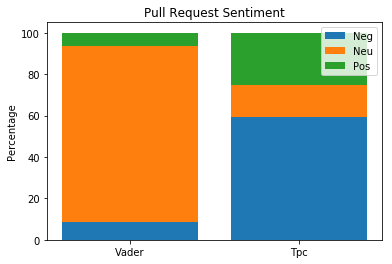

Vader - Negative:     8.80 Neutral:    84.84 Positive:     6.35
T-p.c - Negative:    59.17 Neutral:    15.78 Positive:    25.05


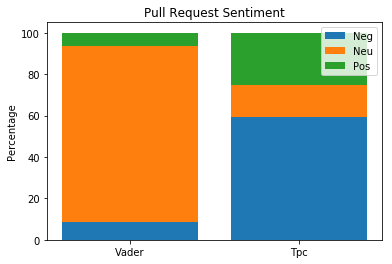

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def makePlot(values): 
    ind = np.arange(2)
    pos = []
    vals = np.array(values)
    p1 = plt.bar(ind, vals[0])
    p2 = plt.bar(ind, vals[1], bottom=vals[0])
    p3 = plt.bar(ind, vals[2], bottom=vals[0]+vals[1])

    plt.ylabel('Percentage')
    plt.title('Pull Request Sentiment')
    plt.xticks(ind, ('Vader', 'Tpc'))
    plt.legend((p1[0], p2[0],p3[0]), ('Neg', 'Neu', 'Pos'))

    plt.show()

import ipywidgets as widgets
ownerVal = 'Enter owner name'
repoVal = 'Enter repo name'
tokenVal = 'Insert Token'

ownerW = widgets.Text(value=ownerVal)
repoW = widgets.Text(value=repoVal)
tokenW = widgets.Text(value=tokenVal)
startB = widgets.Button(description='Start')
display(ownerW, repoW, tokenW, startB)


def on_button_clicked(b):
    ownerVal = ownerW.value
    repoVal = repoW.value
    tokenVal = tokenW.value
    if (ownerVal != '' and repoVal != '' and tokenVal != ''):
        result = acquireRepoData(ownerVal, repoVal, tokenVal)
        makePlot(result)
        
    
startB.on_click(on_button_clicked)

In [ ]:
import numpy as np

ind = np.arrange(2)
pos = []
p1 = plt.bar(ind, , width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()